In [1]:
%%javascript
document.title="numerics"

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [3]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [40]:
#A = pd.read_csv('A.csv', header=None)
#B = pd.read_csv('b.csv', header=None)
path = '/Users/kevinliu/temp/CarNumericsData/'
psi = pd.read_csv(path+'psi.csv', header=None)
psi0 = pd.read_csv(path+'psi0.csv',header=None)
pressure = pd.read_csv(path+'pressure.csv', header=None)
theta1_integrand = pd.read_csv(path+'theta1_integrand.csv',header=None)
h = pd.read_csv(path+'h.csv',header=None)
theta1 = pd.read_csv(path+'theta1.csv', header=None)
print(psi.shape)
#idx = pd.read_csv('neumann_indices.csv', header=None).apply(lambda x: int(x), axis=1)

(100, 100)


In [41]:
I, J = psi.shape

da = (2*np.pi)/J
dr = 1/I

def plot_psi(psi):
    x = np.arange(len(psi))*360/J
    ax = sns.lineplot(data=psi.set_axis(x))
    ax.set_xlabel('α')
    ax.set_ylabel('$\psi$')
    return ax

(dr, da)

(0.01, 0.06283185307179587)

i = 4
ans = pd.DataFrame({'α':np.arange(1,J+1)*360/J, 
                    'Ψ':[np.power(((i+1)*dr),2)*(np.sin(x*da) + np.cos(x*da)) for x in range(1,J+1)]})
ans['num'] = psi.iloc[i]

ans.plot(x='α')

In [ ]:
theta1_integrand.iloc[50,:].plot()

## plot slns

In [17]:
def df_dx(idx, J, dr, da, theta1, theta2):
    alpha = np.arange(da, 2*np.pi+da, da)
    r = (idx+1)*dr;

    df_dr = np.cos(alpha)*theta1 + np.sin(alpha)*theta2;
    df_da = r*(np.cos(alpha)*theta2 - np.sin(alpha)*theta1);
    
    res = df_dr*np.cos(alpha)-df_da*np.sin(alpha)/r 
        #-3*(np.sin(alpha) + np.cos(alpha))
        #df_dr*np.cos(alpha)-df_da*np.sin(alpha)/r 
    return res


def check_sln(psi, idx, J, dr, da, theta1, theta2, rhs_func):
    c_psi = psi.iloc[idx]
    r = (idx+1)*dr
    alpha = np.arange(da, 2*np.pi+da, da)

    psi_2 = c_psi.values
    s1_psi_2 = c_psi.shift(1).fillna(c_psi.values[-1]).values
    s2_psi_2 = c_psi.shift(-1).fillna(c_psi.values[0]).values
    
    psi_1 = psi.iloc[idx-1].values
    psi_3 = psi.iloc[idx+1].values
    
    d2psi_dr2 = (psi_3+psi_1-2*psi_2)/(dr**2)
    dpsi_dr = (psi_3 - psi_1)/(2*dr)
    d2psi_da2 = (s1_psi_2+s2_psi_2-2*psi_2)/(da**2)
    
    num_soln = d2psi_dr2 + dpsi_dr/r + d2psi_da2/np.power(r,2)
    real_soln = -rhs_func(idx, J, dr, da, theta1, theta2)

    return num_soln, real_soln

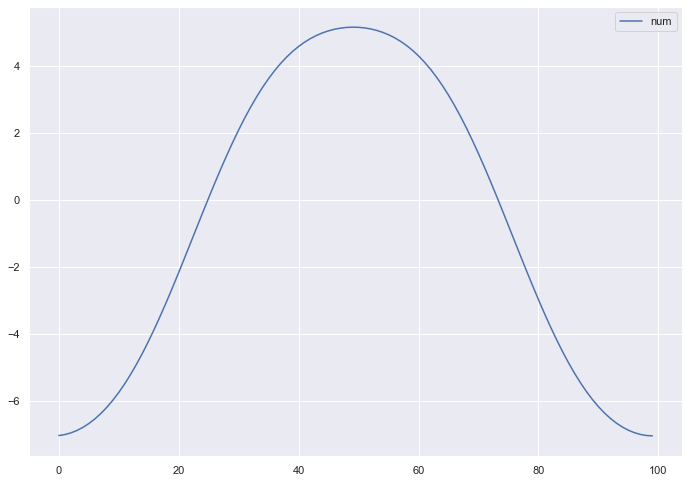

In [69]:
num, rel = check_sln(psi, 2, J, dr, da, -1, 0, df_dx)
pd.DataFrame({'num':num}).plot()

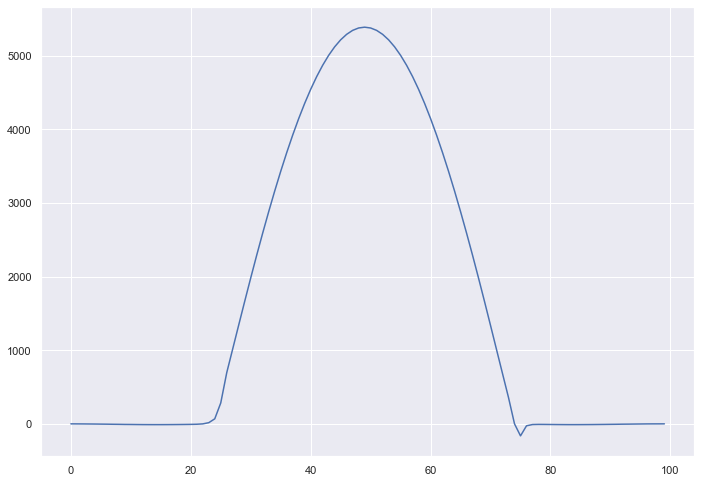

In [31]:
pressure.iloc[99].plot()

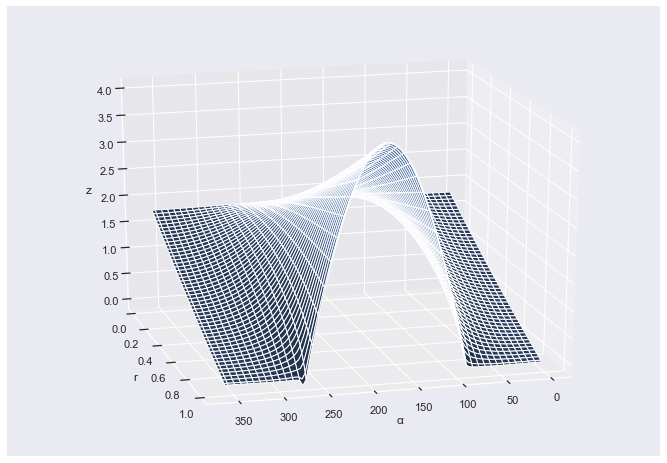

In [25]:
fig = plt.figure()
ax = plt.axes(projection="3d")

alpha = np.arange(1,J+1)*360/J
r = np.arange(1,I+1)/I
alpha, r = np.meshgrid(alpha, r)

z = pressure.values.reshape(I,-1)

ax.plot_surface(alpha,r,z)
ax.set_xlabel('α')
ax.set_ylabel('r')
ax.set_zlabel('z')

ax.view_init(20, 75)

plt.show()

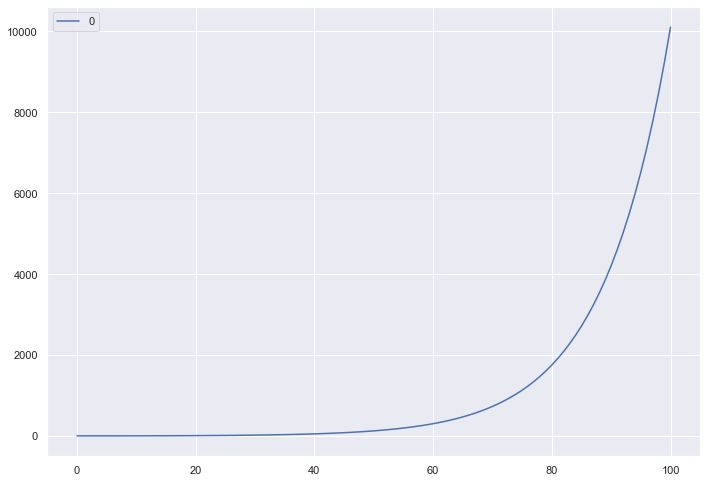

In [32]:
h.plot()

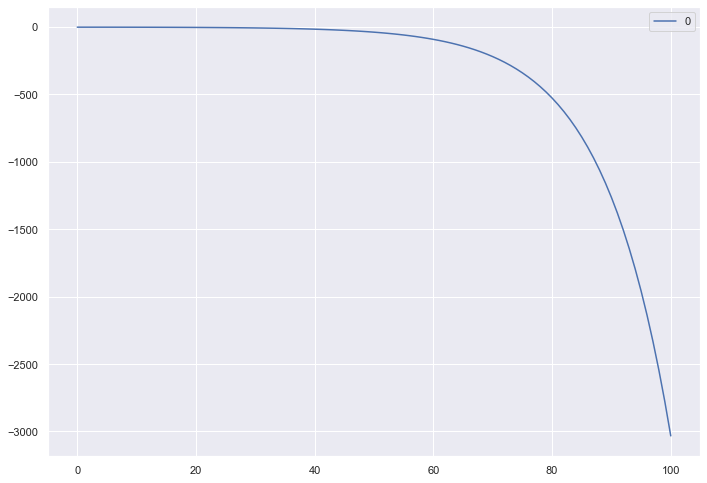

In [33]:
theta1.plot()

# circle numerics

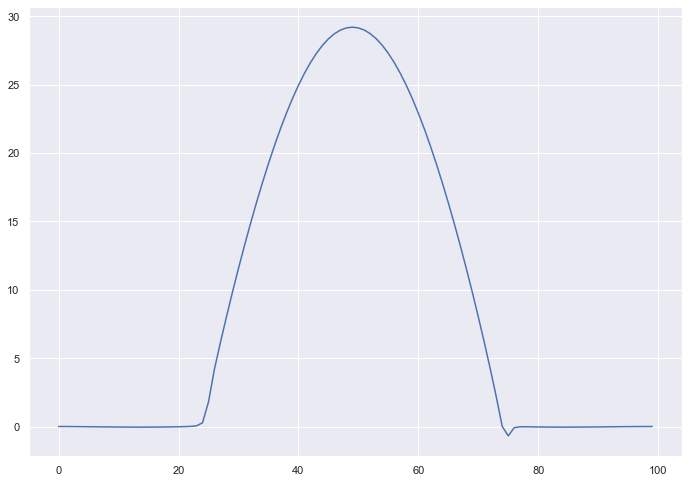

In [42]:
pressure.iloc[99].plot()

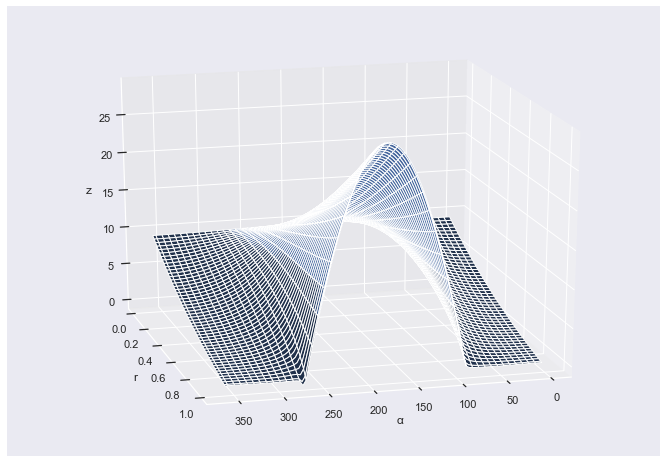

In [43]:
fig = plt.figure()
ax = plt.axes(projection="3d")

alpha = np.arange(1,J+1)*360/J
r = np.arange(1,I+1)/I
alpha, r = np.meshgrid(alpha, r)

z = pressure.values.reshape(I,-1)

ax.plot_surface(alpha,r,z)
ax.set_xlabel('α')
ax.set_ylabel('r')
ax.set_zlabel('z')

ax.view_init(20, 75)

plt.show()

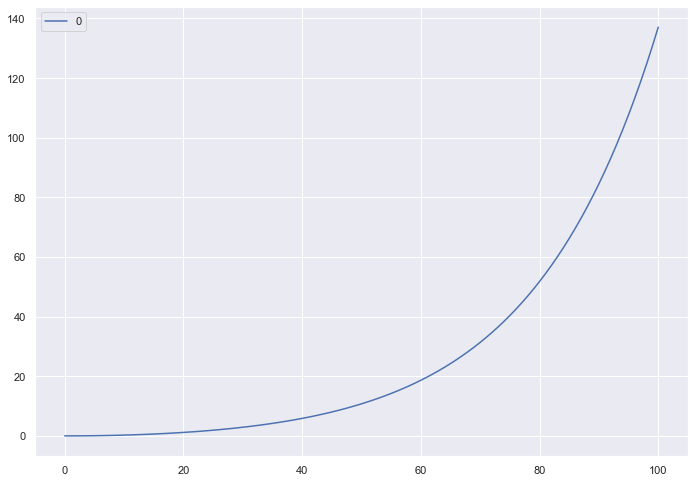

In [44]:
h.plot()

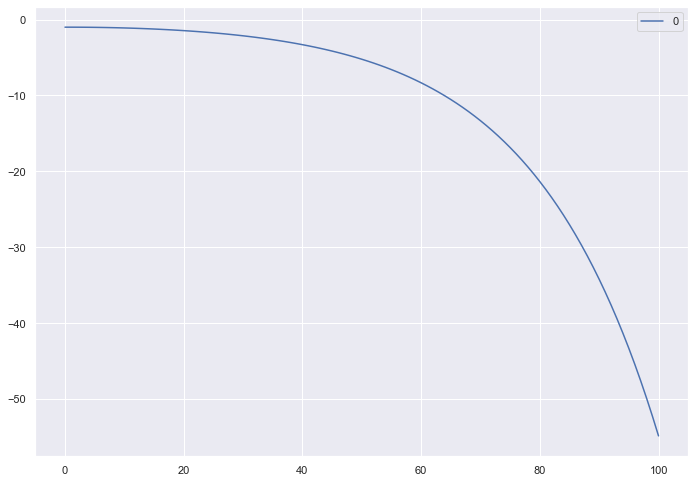

In [45]:
theta1.plot()

## test solution

In [ ]:
num, rel = check_sln(psi, 1, J, dr, da, 1, 0, df_dx)
pd.DataFrame({'num':num,'rel':rel}).plot()
pd.Series(num-rel).describe()

In [ ]:
num, rel = check_sln(psi, 98, J, dr, da, 1, 0, df_dx)
pd.DataFrame({'num':num,'rel':rel}).plot()
pd.Series(num-rel).describe()

In [ ]:
i = 98
r = (i+1)*dr
alphas = (np.arange(J)+1)*2*np.pi/J
real_sln = r**2*(np.sin(alphas) + np.cos(alphas))

In [ ]:
pd.DataFrame({'real': real_sln,'num':psi.iloc[i]}).plot()

In [ ]:
pd.Series(real_sln - psi.iloc[i]).plot()

## v1

In [ ]:
i = I
plot_ids = [i] #1*d_r, 100*d_r = R = 1
for j in plot_ids:
    c_psi = get_psi(psi, j)
    ax = plot_psi(c_psi) 
ax.legend(plot_ids)

ans = pd.DataFrame({'α':np.arange(len(c_psi))*360/J, 
                    'Ψ':[np.power((i*dr),2)*(np.sin(x*da) + np.cos(x*da)) for x in range(1,J+1)]})
ans.plot(x='α',y='Ψ', ax = ax)
ax.legend(['soln r={}*dr'.format(i),'actual r={}*dr'.format(i)])

errs.describe()

In [ ]:
j=2000
i = I
plot_ids = [i] #1*d_r, 100*d_r = R = 1
for j in plot_ids:
    c_psi = get_psi(psi, j)
    ax = plot_psi(c_psi) 
ax.legend(plot_ids)

ans = pd.DataFrame({'α':np.arange(len(c_psi))*360/J, 
                    'Ψ':[np.power((i*dr),2)*(np.sin(x*da) + np.cos(x*da)) for x in range(1,J+1)]})
ans.plot(x='α',y='Ψ', ax = ax)
ax.legend(['soln r={}*dr'.format(i),'actual r={}*dr'.format(i)])

errs.describe()

In [ ]:
i = I
plot_ids = [i] #1*d_r, 100*d_r = R = 1
for j in plot_ids:
    c_psi = get_psi(psi, j)
    ax = plot_psi(c_psi) 
ax.legend(plot_ids)

ans = pd.DataFrame({'α':np.arange(len(c_psi))*360/J, 
                    'Ψ':[np.power((i*dr),2)*(np.sin(x*da) + np.cos(x*da)) for x in range(1,J+1)]})
ans.plot(x='α',y='Ψ', ax = ax)
ax.legend(['soln r={}*dr'.format(i),'actual r={}*dr'.format(i)])

errs.describe()

In [ ]:
j=2000
i= I
plot_ids = [i] #1*d_r, 100*d_r = R = 1
for j in plot_ids:
    c_psi = get_psi(psi, j)
    ax = plot_psi(c_psi) 
ax.legend(plot_ids)

ans = pd.DataFrame({'α':np.arange(len(c_psi))*360/J, 
                    'Ψ':[np.power((i*dr),2)*(np.sin(x*da) + np.cos(x*da)) for x in range(1,J+1)]})
ans.plot(x='α',y='Ψ', ax = ax)
ax.legend(['soln r={}*dr'.format(i),'actual r={}*dr'.format(i)])

errs.describe()

In [ ]:
i = 1000
plot_ids = [i] #1*d_r, 100*d_r = R = 1
for j in plot_ids:
    c_psi = get_psi(psi, j)
    ax = plot_psi(c_psi) 
ax.legend(plot_ids)

ans = pd.DataFrame({'α':np.arange(len(c_psi))*360/J, 
                    'Ψ':[np.power((i*dr),2)*(np.sin(x*da) + np.cos(x*da)) for x in range(1,J+1)]})
ans.plot(x='α',y='Ψ', ax = ax)
ax.legend(['soln r={}*dr'.format(i),'actual r={}*dr'.format(i)])

errs.describe()

In [ ]:
i = 1000
j = 2000
plot_ids = [i] #1*d_r, 100*d_r = R = 1
for j in plot_ids:
    c_psi = get_psi(psi, j)
    ax = plot_psi(c_psi) 
ax.legend(plot_ids)

ans = pd.DataFrame({'α':np.arange(len(c_psi))*360/J, 
                    'Ψ':[np.power((i*dr),2)*(np.sin(x*da) + np.cos(x*da)) for x in range(1,J+1)]})
ans.plot(x='α',y='Ψ', ax = ax)
ax.legend(['soln r={}*dr'.format(i),'actual r={}*dr'.format(i)])

errs.describe()

i = 1
plot_ids = [i] #1*d_r, 100*d_r = R = 1
for j in plot_ids:
    c_psi = get_psi(psi, j)
    ax = plot_psi(c_psi) 
ax.legend(plot_ids)

ans = pd.DataFrame({'x':np.arange(len(c_psi))*360/J, 
                    'psi':[np.power((i*dr),2)*(np.sin(x*da) + np.cos(x*da)) for x in range(1,J+1)]})
ans.plot(x='x',y='psi', ax = ax)
ax.legend(['soln','actual'])

In [ ]:
np.power(2*0.1, -2)

## plot errors

In [ ]:
ax = errs.plot()

ax.set_title('Mean absolute error (numerical v.s. actual) for r in R')

In [ ]:
ax = errs.plot()

ax.set_title('Mean absolute error (numerical v.s. actual) for r in [1 ... 99]*dr')

# 4th order accuracy

In [ ]:
errs.describe()

In [ ]:
ax = errs.plot()

ax.set_title('Mean absolute error (numerical v.s. actual) for r in [1 ... 99]*dr')

pd.Series ([np.power((i*dr),2)*(np.sin(x*da) + np.cos(x*da)) for x in range(1,J+1)]).plot()